In [19]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import yeojohnson
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [20]:
df = pd.read_csv('../data/raw/mbajk_dataset.csv')
df.drop(columns=['Unnamed: 0', 'bike_stands'], inplace=True, axis=1)
df['date'] = pd.to_datetime(df['date'])
df.sort_values(by='date', inplace=True)

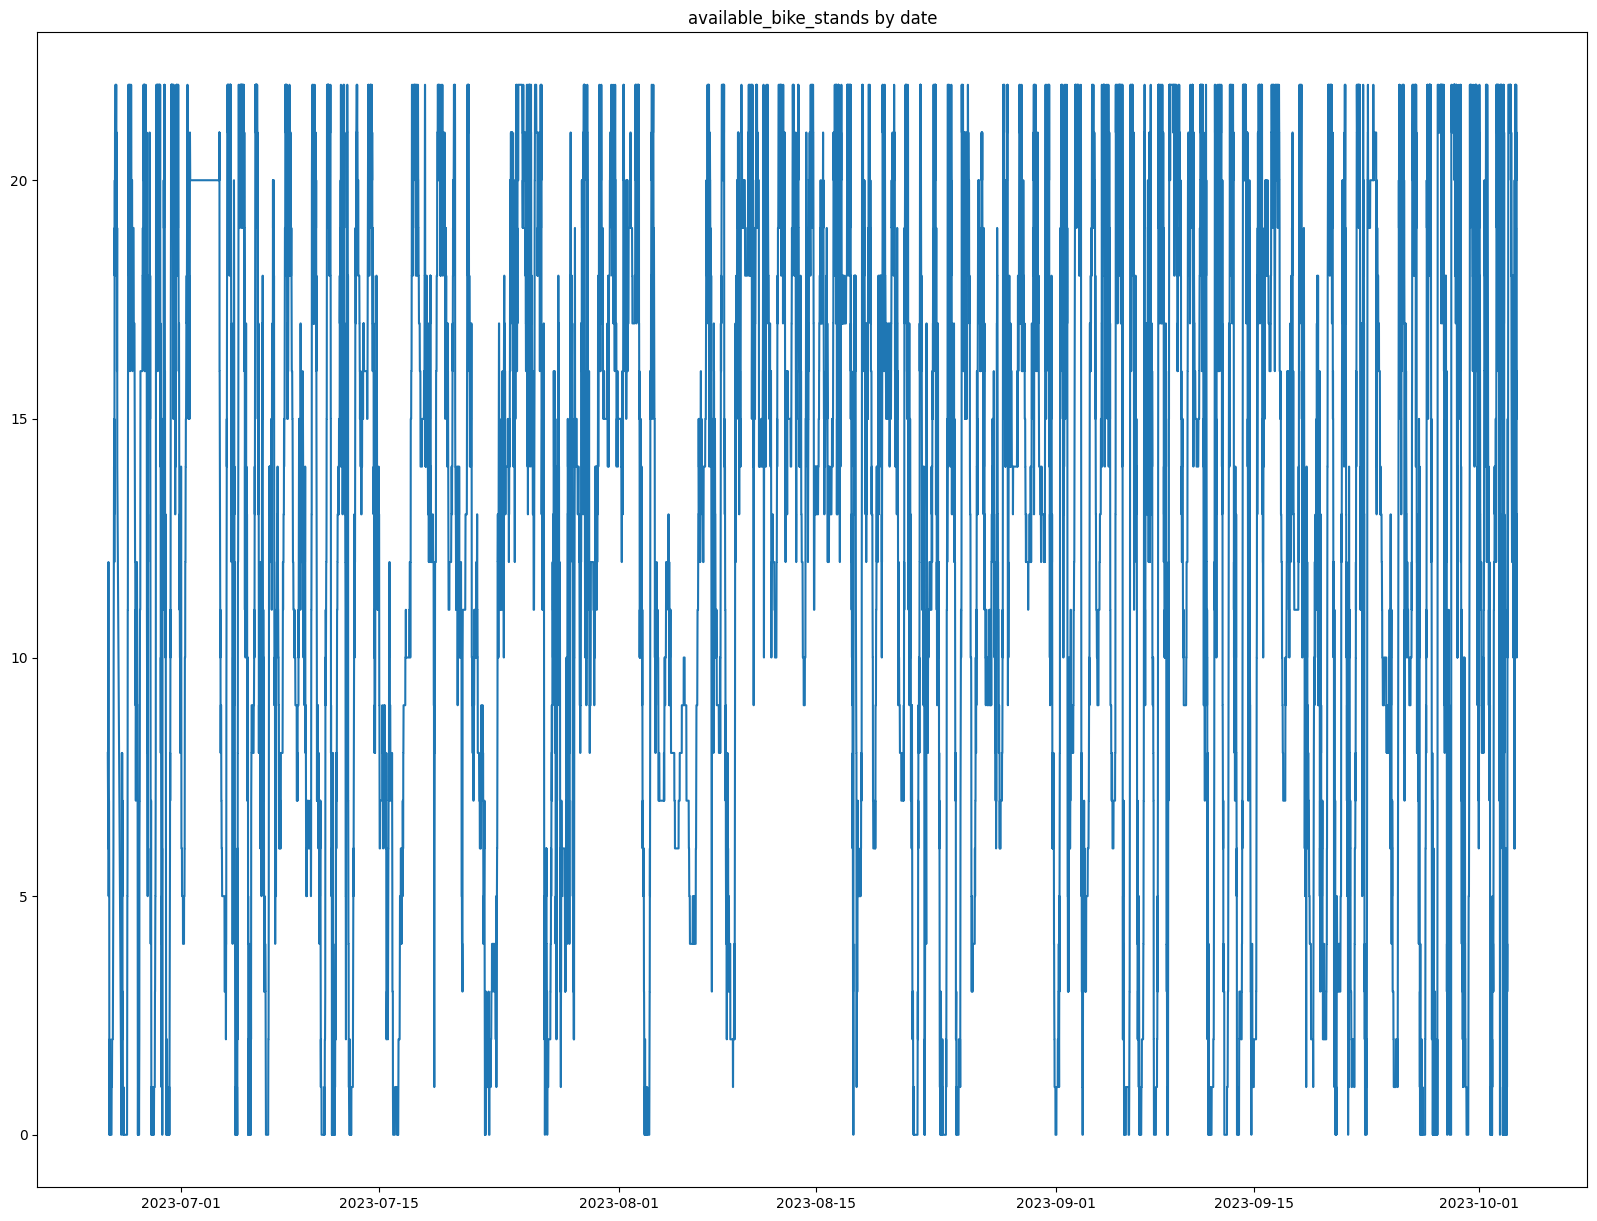

In [21]:
plt.figure(figsize=(20, 15))
plt.plot(df['date'], df['available_bike_stands'])
plt.title(f"available_bike_stands by date")
plt.show()

In [22]:
df.isna().sum()

date                            0
temperature                  1869
relative_humidity               0
dew_point                       0
apparent_temperature            0
precipitation_probability    1308
rain                         2804
surface_pressure                0
available_bike_stands           0
dtype: int64

In [23]:
df.describe()

,temperature,relative_humidity,dew_point,apparent_temperature,precipitation_probability,rain,surface_pressure,available_bike_stands
count,16823.000000,18692.000000,18692.000000,18692.000000,17384.000000,15888.000000,18692.000000,18692.000000
mean,20.858676,71.364701,14.900728,21.807591,20.173608,0.147677,984.187642,13.070190
std,5.114605,17.297704,2.934144,5.767664,32.498770,1.031518,5.244248,6.538118
min,9.300000,27.000000,6.300000,9.000000,0.000000,0.000000,969.400000,0.000000
25%,17.000000,56.000000,13.000000,17.500000,0.000000,0.000000,980.900000,8.000000
50%,20.500000,75.000000,15.000000,21.700000,0.000000,0.000000,984.900000,14.000000
75%,24.500000,86.000000,17.000000,25.600000,31.000000,0.000000,988.100000,19.000000
max,35.800000,100.000000,23.100000,37.000000,100.000000,23.200000,994.500000,22.000000


In [24]:
for col in df.columns[df.isna().any()].tolist():
    df_copy = df.copy().drop(columns=['date'], axis=1)
    X_train = df_copy.dropna().drop(columns=[col], axis=1)
    y_train = df_copy.dropna()[col]
    
    X_empty= df_copy[df_copy[col].isna()].drop(columns=[col], axis=1)

    rfr = RandomForestRegressor(n_estimators=100)
    rfr.fit(X_train, y_train)
    y_empty = rfr.predict(X_empty)
    
    df.loc[df[col].isna(), col] = y_empty

In [25]:
df.isna().sum()

date                         0
temperature                  0
relative_humidity            0
dew_point                    0
apparent_temperature         0
precipitation_probability    0
rain                         0
surface_pressure             0
available_bike_stands        0
dtype: int64

In [26]:
df.describe()

,temperature,relative_humidity,dew_point,apparent_temperature,precipitation_probability,rain,surface_pressure,available_bike_stands
count,18692.000000,18692.000000,18692.000000,18692.000000,18692.000000,18692.000000,18692.000000,18692.000000
mean,20.853705,71.364701,14.900728,21.807591,20.153424,0.142287,984.187642,13.070190
std,5.114761,17.297704,2.934144,5.767664,32.408680,0.994181,5.244248,6.538118
min,9.300000,27.000000,6.300000,9.000000,0.000000,0.000000,969.400000,0.000000
25%,17.000000,56.000000,13.000000,17.500000,0.000000,0.000000,980.900000,8.000000
50%,20.500000,75.000000,15.000000,21.700000,0.000000,0.000000,984.900000,14.000000
75%,24.500000,86.000000,17.000000,25.600000,31.000000,0.000000,988.100000,19.000000
max,35.800000,100.000000,23.100000,37.000000,100.000000,23.200000,994.500000,22.000000


In [27]:
def plot_hists(data):
    fig, ax = plt.subplots(3, 3, figsize=(20, 15))
    ax = ax.flatten()
    for i, column in enumerate(data.columns):
        ax[i].hist(data[column], bins=50, alpha=0.7, color='b')
        ax[i].set_title(column)
    plt.show()

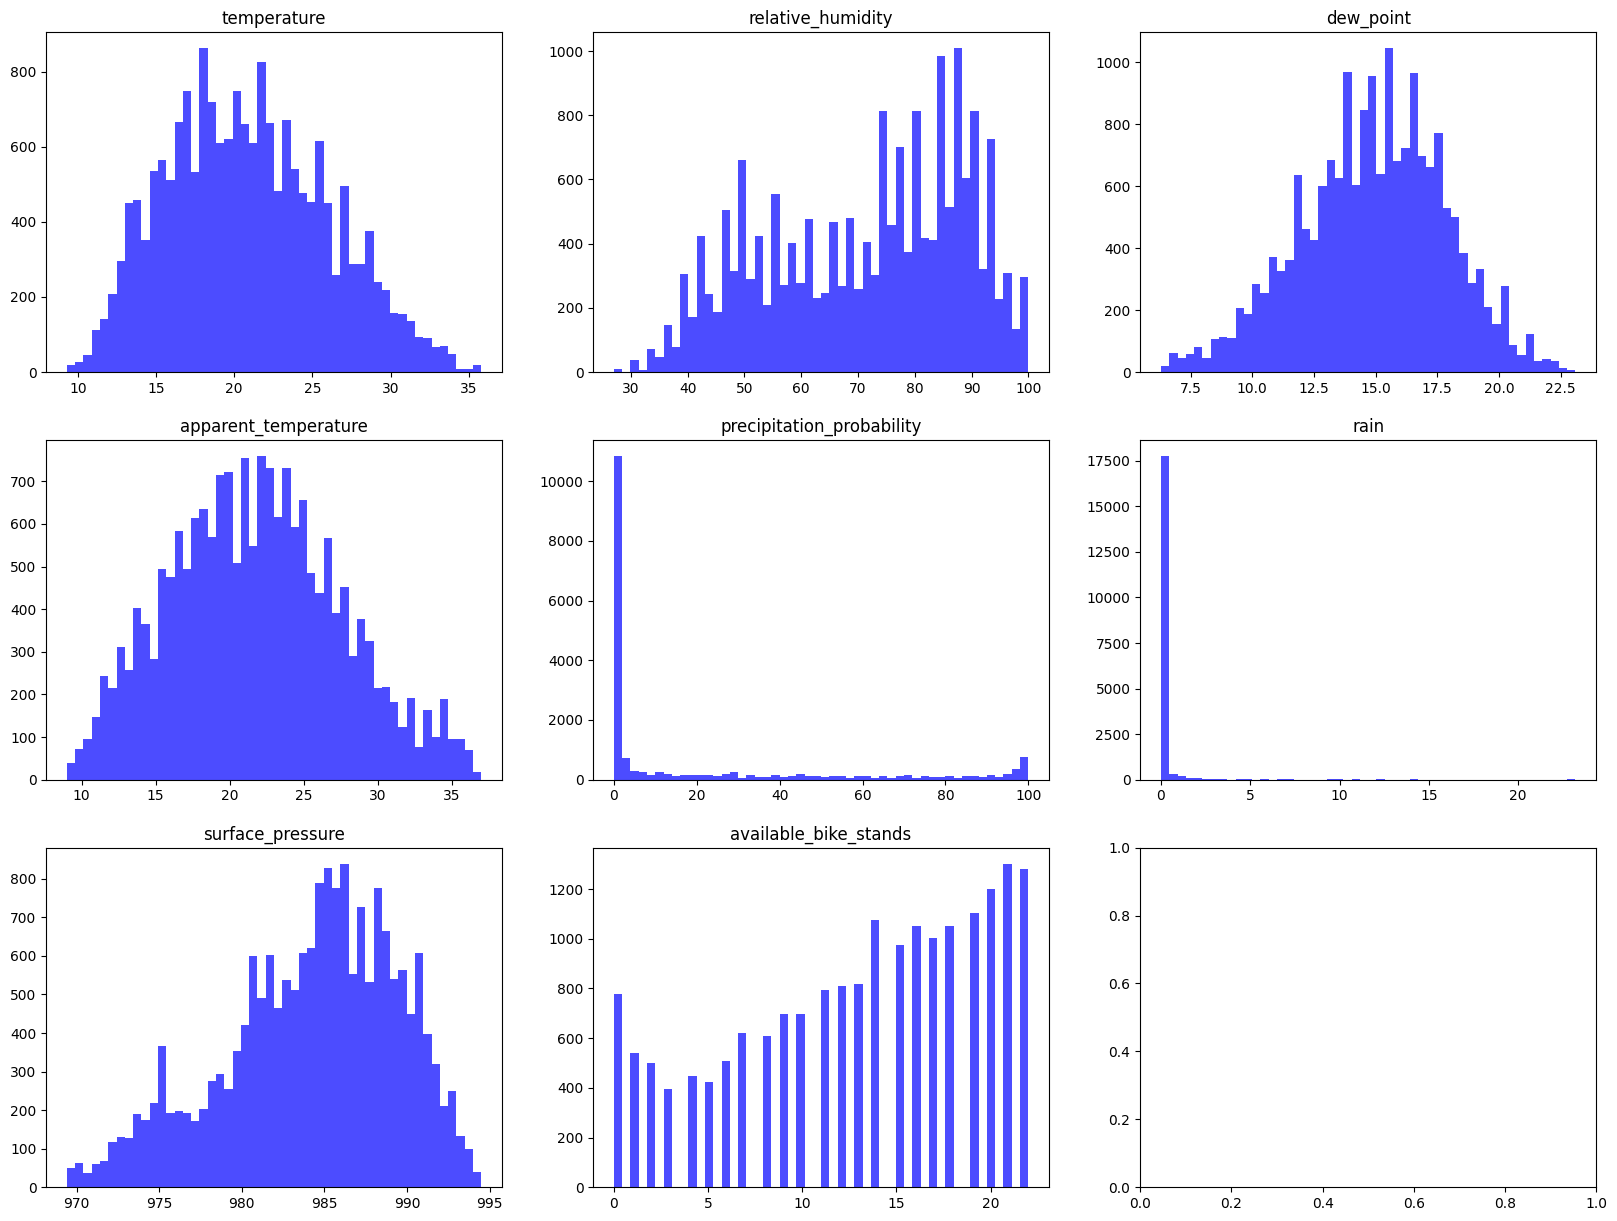

In [28]:
plot_hists(df.drop(columns=['date'], axis=1))

In [29]:
for column in df.drop(columns=['date'], axis=1).columns:
    df[column], _ = yeojohnson(df[column])

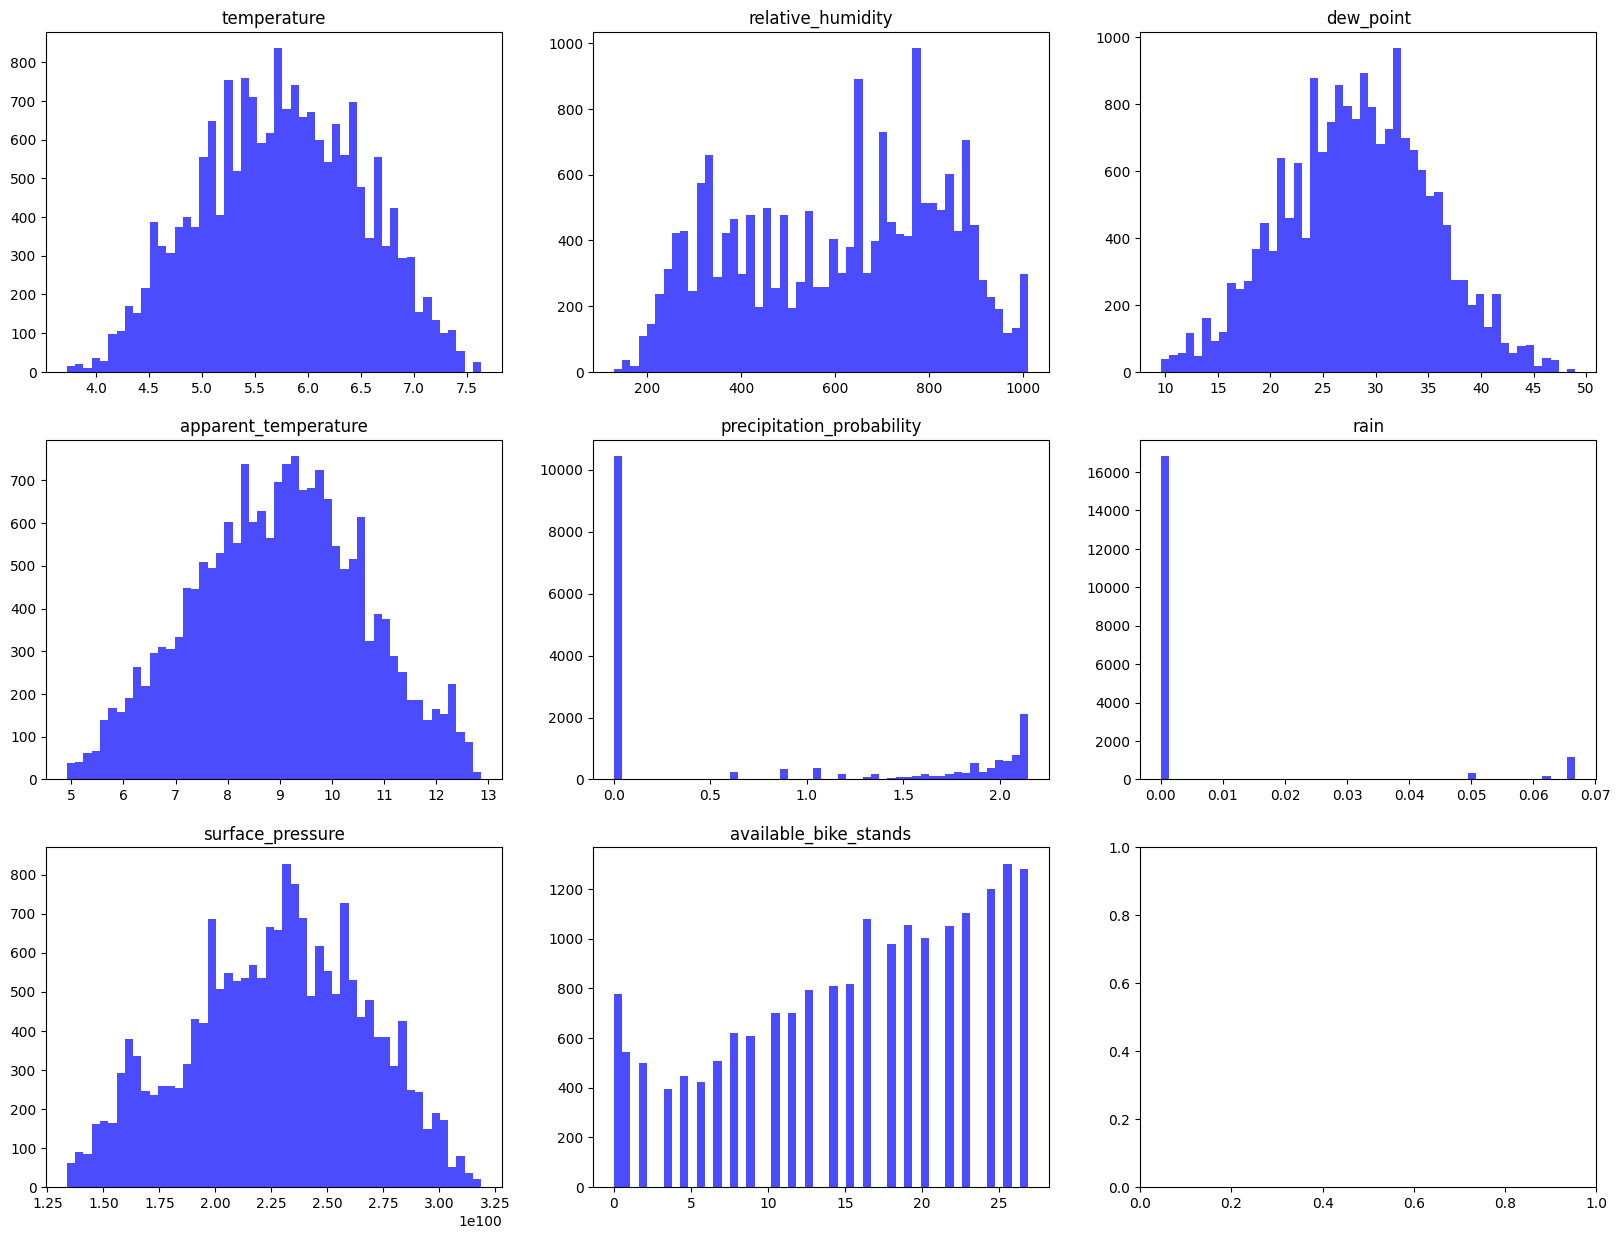

In [30]:
plot_hists(df.drop(columns=['date'], axis=1))

In [31]:
targetScaler = MinMaxScaler()
std = StandardScaler()
mms = MinMaxScaler()

df['available_bike_stands'] = targetScaler.fit_transform(df['available_bike_stands'].values.reshape(-1, 1))
df[['temperature', 'dew_point', 'apparent_temperature', 'surface_pressure']] = std.fit_transform(df[['temperature', 'dew_point', 'apparent_temperature', 'surface_pressure']])
df[['relative_humidity', 'precipitation_probability', 'rain']] = mms.fit_transform(df[['relative_humidity', 'precipitation_probability', 'rain']])

In [32]:
df['time_of_day'] = df['date'].dt.hour // 6 
df['day_of_week'] = df['date'].dt.dayofweek
df = pd.get_dummies(df, columns=['time_of_day', 'day_of_week'], drop_first=True)

df['lagged_available_bike_stands'] = df['available_bike_stands'].shift(1)
lagged_mean = df['lagged_available_bike_stands'].mean()
df['lagged_available_bike_stands'].fillna(lagged_mean, inplace=True)

window_size = 7 
df['rolling_mean_bike_stands'] = df['available_bike_stands'].rolling(window=window_size).mean()
rolled_mean = df['rolling_mean_bike_stands'].mean()
df['rolling_mean_bike_stands'].fillna(rolled_mean, inplace=True)

df['rolling_std_bike_stands'] = df['available_bike_stands'].rolling(window=window_size).std()
rolled_std_mean = df['rolling_std_bike_stands'].mean()
df['rolling_std_bike_stands'].fillna(rolled_std_mean, inplace=True)

df['diff_available_bike_stands'] = df['available_bike_stands'].diff()
diff_mean = df['diff_available_bike_stands'].mean()
df['diff_available_bike_stands'].fillna(diff_mean, inplace=True)

df['temperature_diff'] = df['temperature'] - df['apparent_temperature']
temperature_diff_mean = df['temperature_diff'].mean()
df['temperature_diff'].fillna(temperature_diff_mean, inplace=True)

C:\Users\Tine Šuster\AppData\Local\Temp\ipykernel_17512\435097972.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['lagged_available_bike_stands'].fillna(lagged_mean, inplace=True)
C:\Users\Tine Šuster\AppData\Local\Temp\ipykernel_17512\435097972.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alw

<Axes: >

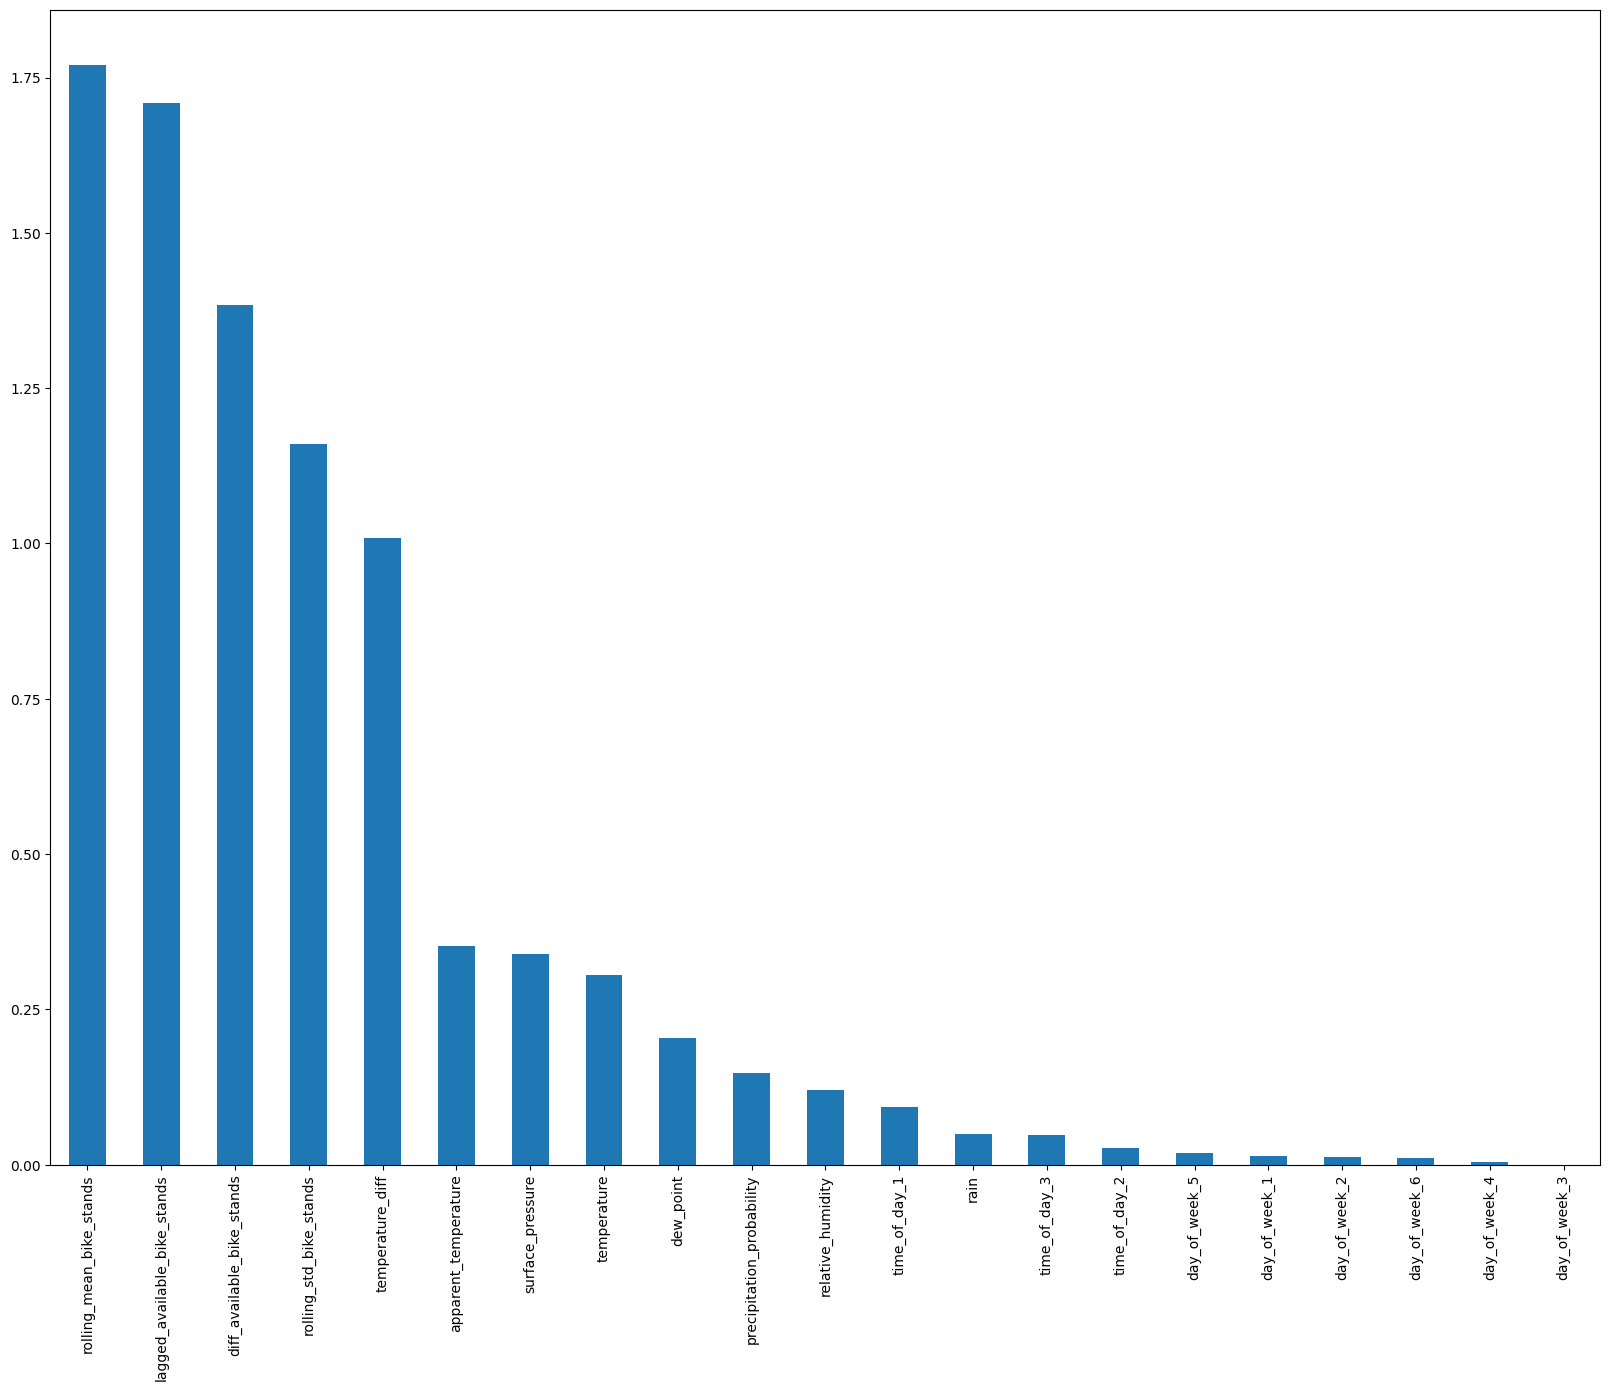

In [33]:
mi = mutual_info_regression(df.drop(columns=['date', 'available_bike_stands']), df['available_bike_stands'])
mi = pd.Series(mi, index=df.drop(columns=['date', 'available_bike_stands']).columns)
mi.sort_values(ascending=False, inplace=True)
mi.plot.bar(figsize=(20, 15))

In [34]:
df.drop(columns=mi[mi < 0.2].index, inplace=True)
df.columns

Index(['date', 'temperature', 'dew_point', 'apparent_temperature',
       'surface_pressure', 'available_bike_stands',
       'lagged_available_bike_stands', 'rolling_mean_bike_stands',
       'rolling_std_bike_stands', 'diff_available_bike_stands',
       'temperature_diff'],
      dtype='object')

In [40]:
df.describe()

,temperature,dew_point,apparent_temperature,surface_pressure,available_bike_stands,lagged_available_bike_stands,rolling_mean_bike_stands,rolling_std_bike_stands,diff_available_bike_stands,temperature_diff
count,1.869200e+04,1.869200e+04,1.869200e+04,1.869200e+04,18692.000000,18692.000000,18692.000000,18692.000000,18692.000000,1.869200e+04
mean,-2.919414e-16,-1.094780e-16,2.797772e-16,-2.676129e-16,0.579267,0.579272,0.579318,0.049509,0.000007,-5.458696e-16
std,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,0.300477,0.300476,0.294561,0.040528,0.054449,2.067286e-01
min,-2.712692e+00,-2.693587e+00,-2.509803e+00,-2.372494e+00,0.000000,0.000000,0.000000,0.000000,-0.577087,-5.272605e-01
25%,-7.218067e-01,-6.702651e-01,-7.208497e-01,-6.988005e-01,0.338621,0.338621,0.351851,0.023620,0.000000,-1.481835e-01
50%,4.409652e-03,4.476491e-03,3.379300e-02,5.308658e-02,0.615540,0.615540,0.622609,0.042111,0.000000,-2.932932e-02
75%,7.488225e-01,7.062312e-01,6.847944e-01,7.315461e-01,0.854183,0.854183,0.840759,0.066205,0.000000,1.188147e-01
max,2.519899e+00,2.993354e+00,2.393158e+00,2.326378e+00,1.000000,1.000000,1.000000,0.477428,0.570468,7.603267e-01


In [35]:
# for column in df.columns:
#     print(f"{column}: {df[column].dtype}")

In [36]:
# df.to_csv('../data/processed/mbajk_dataset.csv', index=False)

In [39]:
import pickle as pkl
pkl.dump(targetScaler, open('../models/target_scaler.pkl', 'wb'))
pkl.dump(std, open('../models/std_scaler.pkl', 'wb'))
pkl.dump(mms, open('../models/mms_scaler.pkl', 'wb'))